In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph, piecewise_extraction

/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
load_dir = Path('../2_pipeline').resolve()

hyp_name = next(filter(lambda d: d.startswith('13c') and d.endswith('1to1'), os.listdir(os.path.join(load_dir,'test_ratio'))))
prep_name = next(filter(lambda d: d.startswith('13b'), os.listdir(load_dir)))
nw_name = next(filter(lambda d: d.startswith('13a'), os.listdir(load_dir)))

nw_dir = load_dir.joinpath(nw_name, 'out')
prep_dir = load_dir.joinpath(prep_name, 'out')
hyp_dir = load_dir.joinpath('test_ratio',hyp_name, 'out')

In [3]:
this_name = '14b_Model_Eval_Holdout_Set_1to1'
out_dir = load_dir.joinpath(this_name, 'out')
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
%%time
nodes = gt.remove_colons(pd.read_csv(nw_dir.joinpath('nodes.csv'), dtype=str))
edges = gt.remove_colons(pd.read_csv(nw_dir.joinpath('edges.csv'), dtype=str))

print('{:,} Nodes'.format(len(nodes)))
print('{:,} Edges'.format(len(edges)))

250,035 Nodes
9,638,511 Edges
CPU times: user 12 s, sys: 3.22 s, total: 15.2 s
Wall time: 15.2 s


In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))
best_param

{'C': 0.3913034420793126,
 'l1_ratio': 0.7698516856063099,
 'w': 0.5285279702303939}

## Routine for extracting information

In [6]:
%%time
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=32)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:45<00:00,  1.48it/s]



Determining degrees for each node and metaedge


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:25<00:00,  2.70it/s]



Weighting matrices by degree with dampening factor 0.5285279702303939...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 118.76it/s]


CPU times: user 32.1 s, sys: 11.1 s, total: 43.2 s
Wall time: 1min 55s


#### Right away lets get the true positives as we will need them later

In [7]:
pos_tups = (mg.edge_df.query('type == "treats_CtD"')[['start_id', 'end_id']]
                      .apply(tuple, axis=1)
                      .tolist())
pos_tups = set(pos_tups)

## Ideal Training Subset

Ideally we need all compounds and diseases associated with training positives, as well as some negatives.

In [8]:
float_size = 32 # bits
bits_per_gb = 8589934592

def print_mem_info(n_comp, n_dis, n_mps):
    print("{:,} Compounds * {:,} Diseases = {:,} C-D Pairs".format(n_comp, n_dis,
                                                                   n_comp * n_dis))
    print("{:,} C-D Pairs * {:,} Metapaths = {:,} Matrix Values".format(n_comp * n_dis,
                                                                    n_mps, 
                                                                    n_comp * n_dis * n_mps))

    print('{:1,.1f} GB of matrix values'.format(n_comp * n_dis * n_mps * float_size / (bits_per_gb)))
    
    print('{:1,.3f} GB per metapath'.format(n_comp * n_dis * float_size / (bits_per_gb)))

In [9]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()

In [10]:
neg_frac = 0.1
rs = 20200225

treat_comps = set(edges.query('type == "treats_CtD"')['start_id'])
# Sample the negatives and subsample, but not Reframe negatvies... keep them as 'Unknown'
keep_comps = set(nodes.query('id not in @treat_comps and id not in @ref_c and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id'])
# Merge togetehr
keep_comps = sorted(list(keep_comps | treat_comps))

treat_dis = set(edges.query('type == "treats_CtD"')['end_id'])
# Sample the negatives 
keep_dis = set(nodes.query('label == "Disease" and id not in @treat_dis')
                    .sample(frac=neg_frac, random_state=rs+1)['id'])
# Merge together
keep_dis = sorted(list(keep_dis | treat_dis))

In [11]:
mp_counts = pd.read_csv(prep_dir.joinpath('all_mp_counts.csv'))
mp_qr = mp_counts.query('subset == "all_pairs" and sim_mp == False and pair_count > 0')
mp_to_extract = mp_qr['mp'].tolist()

mech_mps = pd.read_csv('../0_data/manual/mech_mps.txt', header=None)[0].values
dmdb_feat = mp_counts.query('mp in @mech_mps and subset == "all_pairs" and pair_count > 0')['mp'].unique().tolist()

In [12]:
print_mem_info(len(keep_comps), len(keep_dis), len(mp_to_extract))

11,962 Compounds * 6,190 Diseases = 74,044,780 C-D Pairs
74,044,780 C-D Pairs * 7,012 Metapaths = 519,201,997,360 Matrix Values
1,934.2 GB of matrix values
0.276 GB per metapath


In [13]:
def display_time(seconds):
    result = []
    
    intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )


    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{:1.0f} {}".format(value, name))
    return ', '.join(result)

In [14]:
def sort_mps_for_pw_extraction(n_big_calcs, big_per_block):
    
    big_mp = mp_qr.sort_values('frac', ascending=False).head(n_big_calcs)['mp'].tolist()
    other_mp = list(set(mp_to_extract) - set(big_mp))

    block_size = len(other_mp) // (len(big_mp) // big_per_block)
    n_blocks = ((len(big_mp) + len(other_mp)) // block_size)

    out = []
    for i in range(n_blocks):
        for j in range(big_per_block):
            idx = i*big_per_block + j
            out.append(big_mp[idx])
        out += other_mp[i*block_size:(i+1)*block_size] 
        
    out += list(set(other_mp) - set(out))    
    
    return out, block_size

In [15]:
mp_to_extract, block_size = sort_mps_for_pw_extraction(30, 5)

In [16]:
len(mp_to_extract), block_size

(7012, 1163)

# Build the CV Pipeline

Bring in the functions needed for quick processing

In [17]:
from scipy.sparse import issparse, csc_matrix, csr_matrix

from data_tools.ml import get_model_coefs, MeanScaledArcsinhTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.metrics import roc_auc_score, average_precision_score

from xgboost import XGBClassifier

In [18]:
def cor_selector(X, y, feature_names, num_feats):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in range(X.shape[1]):
        if issparse(X):
            x = X[:, i].A.reshape(len(y))
        else:
            x = X[:, i]
        cor = np.corrcoef(x, y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = np.array(feature_names)[np.argsort(np.abs(cor_list))[-num_feats:].tolist()].tolist()    
    # feature selection? 0 for not select, 1 for select
    return [True if i in cor_feature else False for i in feature_names]

def chi2_selector(X, y, num_feats):
    this_selector = SelectKBest(chi2, k=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()

def rfe_selector(X, y, num_feats, random_state=None):
    this_selector = RFE(estimator=LogisticRegression(C=.1, solver='liblinear', random_state=random_state), 
                        n_features_to_select=num_feats, step=.2, verbose=5)
    this_selector.fit(X, y)
    return this_selector.get_support()

def embeded_lr_selector(X, y, num_feats, random_state=None):
    this_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', random_state=random_state), 
                                    max_features=num_feats)
    this_selector.fit(X, y)

    return this_selector.get_support()

def embeded_rf_selector(X, y, num_feats, n_jobs, random_state=None):
    rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=n_jobs, random_state=random_state)
    this_selector = SelectFromModel(rfc, max_features=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()

def embeded_xgb_selector(X, y, num_feats, n_jobs=1, random_state=None):
    # XGBoost takes 0 as default random state
    if random_state is None:
        random_state = 0
    # Paramaters optimized for speed, rather than accuracy (as we have 5 other estimators also providing votes)
    xgbc = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=.16, min_child_weight=1, colsample_bytree=.8,
                         n_jobs=n_jobs, random_state=random_state)
    this_selector = SelectFromModel(xgbc, max_features=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_features=100, min_selections=4, n_jobs=1, feature_names=None, always_keep=None,
                 random_state=None):
        self.num_features = num_features
        self.min_selections = min_selections
        self.n_jobs = n_jobs
        self.feature_names = feature_names
        self.always_keep = always_keep
        self.random_state = random_state
        
    def fit(self, X, y=None):
                
        X_norm = MaxAbsScaler().fit_transform(X)
        if issparse(X):
            if type(X) != csc_matrix:
                X = X.tocsc()
            X_norm = X_norm.tocsc()
        
        print('Running Cor')
        cor_support = cor_selector(X, y, self.feature_names, self.num_features)
        print('Running Chi2')
        chi_support = chi2_selector(X_norm, y, self.num_features)
        print('Running RFE')
        rfe_support = rfe_selector(X_norm, y, self.num_features, self.random_state)
        print('Running LR')
        embeded_lr_support = embeded_lr_selector(X_norm, y, self.num_features, self.random_state)
        print('Running RF')
        embeded_rf_support = embeded_rf_selector(X, y, self.num_features, 
                                                 n_jobs=self.n_jobs, random_state=self.random_state)
        print('Running XG')
        embeded_xgb_support = embeded_xgb_selector(X, y, self.num_features, 
                                                   n_jobs=self.n_jobs, random_state=self.random_state)
        
        feature_selection_df = pd.DataFrame({'feature':self.feature_names, 'pearson':cor_support, 'chi_2':chi_support, 
                                             'rfe':rfe_support, 'logistics':embeded_lr_support,
                                             'random_forest':embeded_rf_support, 'xgboost':embeded_xgb_support})  

        feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)
        self.feature_selection_df_ = feature_selection_df
        
        keep_features = feature_selection_df.query('total >= {}'.format(self.min_selections))['feature'].tolist()
        
        # Keep the features that we always want (e.g. domain expertise)
        if self.always_keep is not None:
            keep_features.extend(self.always_keep)
        
        self.keep_features_ = [f for f in self.feature_names if f in keep_features]
        
        return self
    
    def transform(self, X, y=None):
        
        if issparse(X) and type(X) != csc_matrix:
            X = X.tocsc()
        return X[:, [i for i, f in enumerate(self.feature_names) if f in self.keep_features_]]

In [19]:
fs = pickle.load(open(hyp_dir.joinpath('feature_selector.pkl'), 'rb'))
mp_to_extract = list(set(fs.keep_features_) | set(dmdb_feat))

In [20]:
enet_params = {k: v for k, v in best_param.items() if k != 'w'}

post_extraction_pipeline = Pipeline(
    [('transformer', MeanScaledArcsinhTransformer()),
     ('maxabs_scale', MaxAbsScaler()),
     ('e_net', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, **enet_params))], verbose=True)

In [21]:
keep_comps = np.array(keep_comps)

In [22]:
%%time

start = time()

(pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=mp_to_extract, start_nodes=keep_comps, end_nodes=keep_dis, 
                   return_sparse=True, sparse_df=False, verbose=True, n_jobs=30)
# Split the Training and Testing
print('Shaping Matricies...')
dwpc = dwpc.tocoo().tocsr()

print('Getting Target Values')
y = []
for row in tqdm(pairs.itertuples(), total=len(pairs)):
    # pos_tups defined several cells above
    if set([(row.chemicalsubstance_id, row.disease_id)]) & pos_tups:
        y.append(1)
    else:
        y.append(0)
        
y = np.array(y)
pairs['status'] = y

# subset so that we're training only with nonzero dwpc rows
# Get the training examples that have metapaths
nz_index = pairs[dwpc.getnnz(1)>0].index
# have the number of postivies to get 100x this for the negatives.
n_pos = pairs['status'].sum()
# Sample the nonzero negative examples at a rate of 1x the positive samples
neg_index = pairs.loc[nz_index].query('status == 0').sample(n=1*n_pos, random_state=rs+10).sort_index().index
# and of course take the training postivies
pos_index = pairs.query('status == 1').index
# Union the two
train_index = pos_index.union(neg_index)

        
# Fit the model and get results
print('Training Model')
post_extraction_pipeline.fit(dwpc[train_index, :], y[train_index])

print('Getting Model Coef')
coef = get_model_coefs(post_extraction_pipeline[-1], dwpc, mp_to_extract).sort_values('coef', ascending=False)

# Save model
coef.to_csv(out_dir.joinpath('coef.csv'), index=False)
pickle.dump(post_extraction_pipeline, open(out_dir.joinpath('model.pkl'), 'wb'))

print('Training took: ' + display_time(time() - start))
print('\n\n')

Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 252/252 [03:29<00:00,  1.21it/s]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 252/252 [02:22<00:00,  1.76it/s]


Stacking columns...
Shaping Matricies...
Getting Target Values


  0%|          | 0/74044780 [00:00<?, ?it/s]

Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   1.0s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  23.1s
Getting Model Coef
Training took: 14 minutes, 8 seconds



CPU times: user 8min 16s, sys: 3min 13s, total: 11min 30s
Wall time: 14min 8s


In [23]:
coef.head(10)

,feature,coef,zcoef
46,CafBPawD,7.551297,0.000586
45,CafBPpoCtD,3.469716,0.000213
139,CafBPawPmCtD,3.421359,0.000035
97,CafGrxCtD,3.184053,0.000105
52,CinGpoBPawPpsD,2.098644,0.000017
50,CaGpoBPpoCtD,2.037292,0.000011
53,CafGpoPWpoCtD,1.993663,0.000013
212,CafGpoPWpoGmD,1.850029,0.000036
63,CaGpoPWpoCtD,1.834229,0.000011
143,CafGpoApoCplD,1.749087,0.000003


# Test against the holdout set

In [24]:
tgt = pd.read_csv(nw_dir.joinpath('holdout_set.csv'), dtype=str)

In [25]:
test_pos_tups = (tgt[['start_id', 'end_id']]
                      .apply(tuple, axis=1)
                      .tolist())
test_pos_tups = set(test_pos_tups)

In [26]:
test_comps = set(tgt['start_id'].unique())
test_comps = set(nodes.query('id not in @test_comps and ' +
                             'id not in @keep_comps and '+
                             'id not in @ref_c and '+
                             'label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs+4)['id'])
test_comps = list(set(tgt['start_id'].unique()) | test_comps)

test_dis = set(tgt['end_id'].unique())
test_dis = set(nodes.query('id not in @test_dis and ' +
                             'id not in @keep_dis and '+
                             'label == "Disease"')
                                    .sample(frac=neg_frac, random_state=rs+5)['id'])
test_dis = list(set(tgt['end_id'].unique()) | test_dis)

In [27]:
%%time

start = time()

(pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=mp_to_extract, start_nodes=test_comps, end_nodes=test_dis, 
                   return_sparse=True, sparse_df=False, verbose=True, n_jobs=30)

print('Getting Target Values')
y = []
for row in tqdm(pairs.itertuples(), total=len(pairs)):
    # pos_tups defined several cells above
    if set([(row.chemicalsubstance_id, row.disease_id)]) & test_pos_tups:
        y.append(1)
    else:
        y.append(0)
        
# Fit the model and get results
print('Getting Probabilities')
y_proba = post_extraction_pipeline.predict_proba(dwpc)[:, 1]

# Get metrics
roc_auc = roc_auc_score(y, y_proba)
avg_prec = average_precision_score(y, y_proba)
print('AUROC: {:1.4f}'.format(roc_auc))
print('AUPR: {:1.4f}'.format(avg_prec))

pairs['status'] = y
pairs['proba'] = y_proba

# Save results
pairs.to_csv(out_dir.joinpath('results.csv'), index=False)

print('Eval took: ' + display_time(time() - start))
print('\n\n')

Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 252/252 [02:34<00:00,  1.63it/s]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.30it/s]


Stacking columns...
Getting Target Values


  0%|          | 0/19861116 [00:00<?, ?it/s]

Getting Probabilities
AUROC: 0.7880
AUPR: 0.0208
Eval took: 6 minutes, 19 seconds



CPU times: user 3min 12s, sys: 36.2 s, total: 3min 49s
Wall time: 6min 19s


## Load back in all the results and plot

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_tools import plotting as pt

In [29]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [30]:
pairs = pd.read_csv(out_dir.joinpath('results.csv'))

In [31]:
zero_prob = pairs['proba'].value_counts().index[0]
y = pairs.query('proba != @zero_prob')['status']
y_proba = pairs.query('proba != @zero_prob')['proba']

In [32]:
pairs['status'].sum()

13605

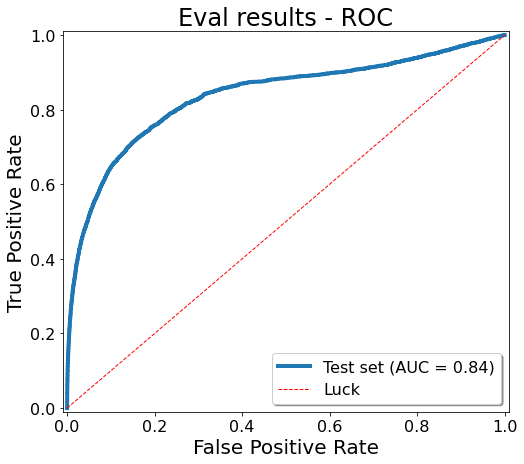

In [33]:
pt.graph_single_roc(y, y_proba, 'Test set')
pt.graph_roc_boilerplate('Eval results - ROC');
#plt.legend(loc=7, bbox_to_anchor=(1.2, .5));

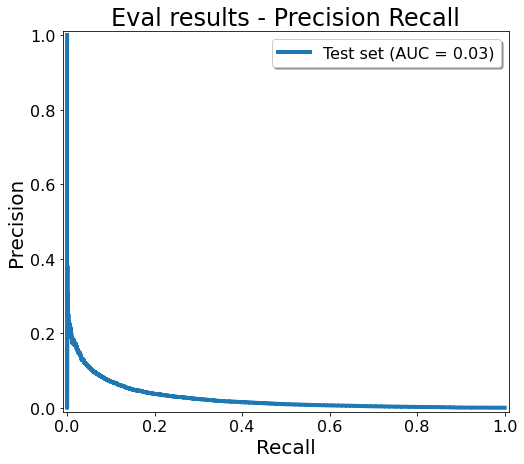

In [34]:
pt.graph_single_prc(y, y_proba, 'Test set')
pt.graph_prc_boilerplate('Eval results - Precision Recall');
#plt.legend(loc=7, bbox_to_anchor=(1.2, .5));